In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# 1. Load the data
file_path = r"/content/drive/MyDrive/MuRG/Data/data.xlsx"
data = pd.read_excel(file_path)
data = data.dropna(axis=1)
df = pd.DataFrame(data)
print(f"\nLabel distribution: {df['Label'].value_counts()}")
df.head()


Label distribution: Label
0    190
1    175
Name: count, dtype: int64


,Drug_Names,SMILES,Label,Source,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,Abemaciclib,CCN1CCN(CC1)CC2=CN=C(C=C2)NC3=NC=C(C(=N3)C4=CC...,0,CHEMBL,14.938285,14.938285,0.009538,-0.636008,0.380688,15.108108,...,0,0,0,0,0,0,0,0,0,0
1,Acalabrutinib,CC#CC(=O)N1CCC[C@H]1C2=NC(=C3N2C=CN=C3N)C4=CC=...,0,CHEMBL,12.610319,12.610319,0.209630,-0.260221,0.446551,15.000000,...,0,0,0,0,0,0,0,0,0,0
2,Acetazolamide,CC(=O)NC1=NN=C(S1)S(=O)(=O)N,1,DrugBank,10.704978,10.704978,0.107894,-3.824175,0.631859,11.230769,...,0,1,0,0,0,0,0,0,0,0
3,Acetophenone,CC(=O)C1=CC=CC=C1,1,DrugBank,10.645370,10.645370,0.120926,0.120926,0.517047,9.000000,...,0,0,0,0,0,0,0,0,0,0
4,Acitretin,CC1=CC(=C(C(=C1/C=C/C(=C/C=C/C(=C/C(=O)O)/C)/C...,1,DrugBank,10.557328,10.557328,0.701850,-0.931877,0.579454,13.083333,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# Prepare the data
X = data.drop(['Drug_Names', 'SMILES', 'Label', 'Source'], axis=1)
y = data['Label']
print(f"\nNumber of Drugs: {X.shape[0]}")
print(f"Number of Features: {X.shape[1]}")
print("Missing values in features:", X.isnull().sum().sum())


Number of Drugs: 365
Number of Features: 205
Missing values in features: 0


In [8]:
# 2. Basic data exploration
print("\n" + "="*60)
print("DATA EXPLORATION")
print("="*60)

# Check label distribution
label_counts = y.value_counts()
n_total = len(y)
n_labeled_positives = label_counts[1] if 1 in label_counts else 0
n_unlabeled = label_counts[0] if 0 in label_counts else 0

print(f"Total molecules: {n_total}")
print(f"Labeled positives: {n_labeled_positives}")
print(f"Unlabeled: {n_unlabeled}")
print(f"P(S=1) - Proportion labeled: {n_labeled_positives/n_total:.4f}")


DATA EXPLORATION
Total molecules: 365
Labeled positives: 175
Unlabeled: 190
P(S=1) - Proportion labeled: 0.4795


In [9]:
# 3. Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Label distribution in training set: {pd.Series(y_train).value_counts()}")
print(f"Label distribution in test set: {pd.Series(y_test).value_counts()}")


Training set size: 292
Test set size: 73
Label distribution in training set: Label
0    152
1    140
Name: count, dtype: int64
Label distribution in test set: Label
0    38
1    35
Name: count, dtype: int64


In [10]:
# 4. Estimate c using Elkan-Noto method
print("\n" + "="*60)
print("STEP 1: ESTIMATING c (Labeling Probability)")
print("="*60)

# Train a classifier to distinguish Labeled vs Unlabeled
clf_labeled = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_features='sqrt',  # Prevent overfitting with high-dimensional data
    max_depth=10
)

clf_labeled.fit(X_train, y_train)

# Get the labeled positive examples from training set
labeled_positives_mask = (y_train == 1)
X_labeled_positives = X_train[labeled_positives_mask]

print(f"Number of labeled positives in training set: {len(X_labeled_positives)}")

if len(X_labeled_positives) == 0:
    raise ValueError("No positive examples found in training set!")

# Predict probability of being labeled for these known positives
prob_labeled = clf_labeled.predict_proba(X_labeled_positives)[:, 1]

print(f"\nProbability distribution for labeled positives:")
print(f"Min: {prob_labeled.min():.4f}")
print(f"Max: {prob_labeled.max():.4f}")
print(f"Mean: {prob_labeled.mean():.4f}")
print(f"Std: {prob_labeled.std():.4f}")

# Estimate c as the average probability that positive examples are labeled
c_estimate = np.mean(prob_labeled)
print(f"\n ESTIMATED c = {c_estimate:.4f}")
print(f"  This means approximately {c_estimate*100:.1f}% of positive molecules get labeled")



STEP 1: ESTIMATING c (Labeling Probability)
Number of labeled positives in training set: 140

Probability distribution for labeled positives:
Min: 0.3695
Max: 0.9999
Mean: 0.8804
Std: 0.0996

 ESTIMATED c = 0.8804
  This means approximately 88.0% of positive molecules get labeled


In [11]:
# 5. Calculate class prior Pi
print("\n" + "="*60)
print("STEP 2: CALCULATING CLASS PRIOR π")
print("="*60)

# P(S=1) is observable from our data
P_labeled = n_labeled_positives / n_total

# Using the relationship: Pi = P(S=1) / c
pi_estimate = P_labeled / c_estimate

print(f"Observable P(S=1): {P_labeled:.4f} ({n_labeled_positives}/{n_total})")
print(f"Estimated c: {c_estimate:.4f}")
print(f"ESTIMATED Pi (Class Prior) = {pi_estimate:.4f}")
print(f"This means approximately {pi_estimate*100:.1f}% of all molecules are positive")



STEP 2: CALCULATING CLASS PRIOR π
Observable P(S=1): 0.4795 (175/365)
Estimated c: 0.8804
ESTIMATED Pi (Class Prior) = 0.5446
This means approximately 54.5% of all molecules are positive


In [12]:
# 6. Calculate hidden positives
total_estimated_positives = pi_estimate * n_total
hidden_positives = total_estimated_positives - n_labeled_positives

print(f"\n HIDDEN POSITIVES ESTIMATION:")
print(f"Total estimated positives: {total_estimated_positives:.1f} molecules")
print(f"Labeled positives: {n_labeled_positives} molecules")
print(f"Hidden positives in unlabeled set: {hidden_positives:.1f} molecules")
print(f"Completeness of labeling: {(n_labeled_positives/total_estimated_positives)*100:.1f}%")


 HIDDEN POSITIVES ESTIMATION:
Total estimated positives: 198.8 molecules
Labeled positives: 175 molecules
Hidden positives in unlabeled set: 23.8 molecules
Completeness of labeling: 88.0%


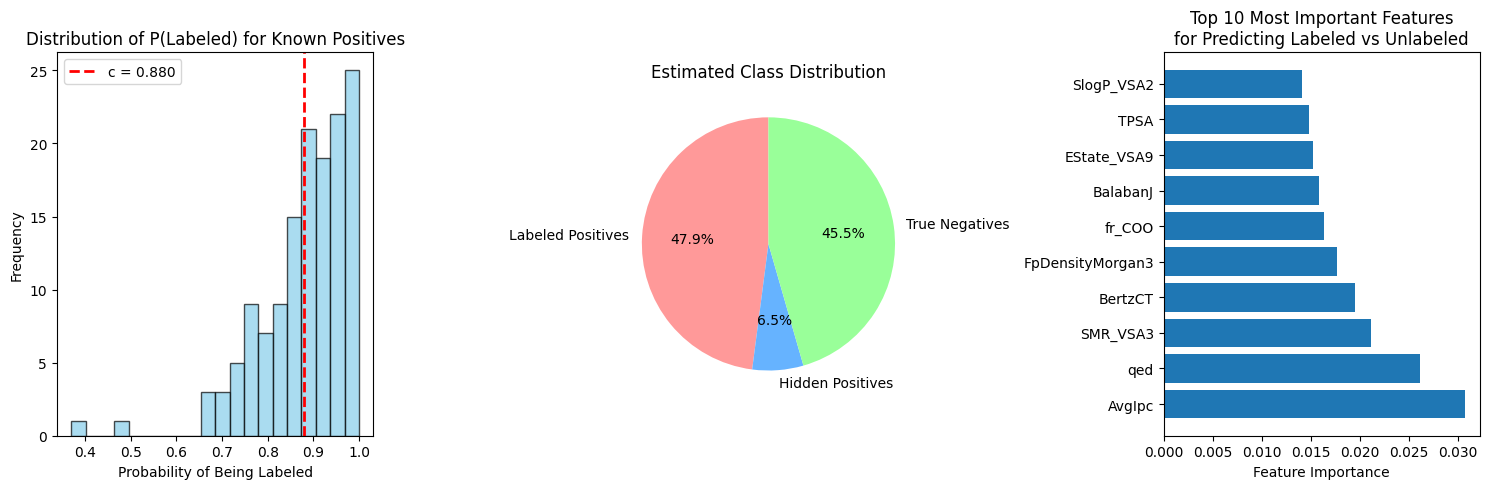

In [13]:
# 7. Visualize the results
plt.figure(figsize=(15, 5))

# Plot 1: Distribution of probabilities for labeled positives
plt.subplot(1, 3, 1)
plt.hist(prob_labeled, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(c_estimate, color='red', linestyle='--', linewidth=2, label=f'c = {c_estimate:.3f}')
plt.xlabel('Probability of Being Labeled')
plt.ylabel('Frequency')
plt.title('Distribution of P(Labeled) for Known Positives')
plt.legend()

# Plot 2: Class proportions
plt.subplot(1, 3, 2)
labels = ['Labeled Positives', 'Hidden Positives', 'True Negatives']
sizes = [n_labeled_positives, hidden_positives, n_total - total_estimated_positives]
colors = ['#ff9999', '#66b3ff', '#99ff99']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Estimated Class Distribution')

# Plot 3: Feature importance
plt.subplot(1, 3, 3)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': clf_labeled.feature_importances_
}).sort_values('importance', ascending=False).head(10)  # Top 10 features

plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 10 Most Important Features\nfor Predicting Labeled vs Unlabeled')
plt.tight_layout()

plt.show()